## Sentiment modelling

In the following, we briefly explore the labeled tweet dataset, setup preprocessing and an ML-Pipeline for training and inference.
We aim for a lean and fast model, distilled from a large language model through the `tweet_sentiments` dataset.

Logistic regression would be a suitable learner since we will be using a sparse representation (term frequencies) for the text and we only have three classes.
However, since tweets will usually contain nuanced language, slangs and emojis, a transformer might work better.
We first investigate logistic regression and, if the performance is not suitable for our use case, try a transformer after wards.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from common import SENTIMENTS, SENTIMENT_LABELS
from tweet_preprocessor import TweetPreprocessor

In [2]:
SEED = 1337

In [3]:
df = pd.read_csv('../data/tweet_sentiments.csv')
df.head()

,sentiment,text
0,2,@tonigirl14 love you toooooo!! TG LOL Gngb
1,0,@jun6lee I told myself: Don't click on this li...
2,2,The man who rendered his voice to Mickey Mouse...
3,2,@Shontelle_Layne I think red would be nice. O...
4,1,@Silverlines - I guess. 'Cause one of her twee...


#### Exploring the data

We have much less samples for negative tweets — We might need to subsample the other two or put more weight on negative samples.

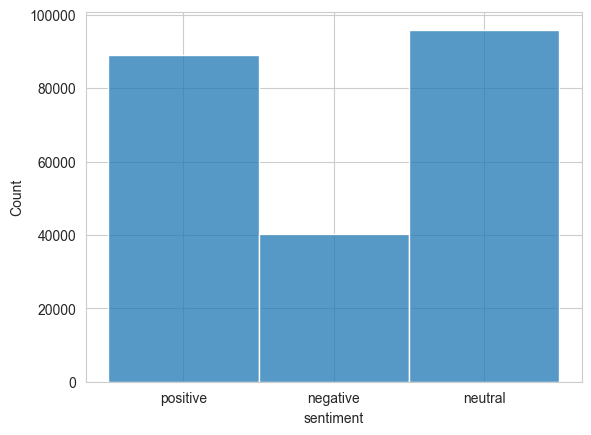

In [3]:
sns.histplot(df.sentiment.map(SENTIMENT_LABELS), discrete=True)
plt.show()

In [32]:
len(df[df.sentiment == SENTIMENTS["missing"]])

0

The positive tweets contain expected and common words like "live" and "good".
While likely being used in a positive context, they do not necessarily have to exhibit a positive meaning - Like sarcasm.

The negative tweets surprisingly do not contain a lot of, or rather not frequently, swear words.
Combined with the amount of negative tweets, our model will likely have trouble with this sentiment.

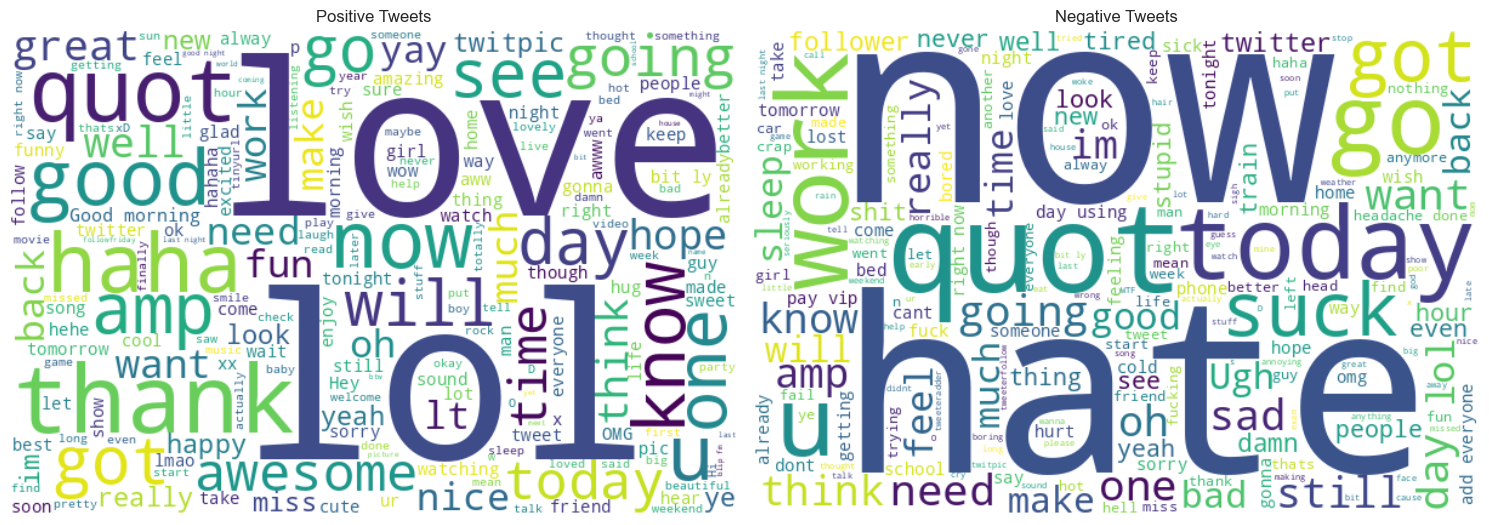

In [30]:
plt.figure(figsize=(15,8))
plt.subplot(121)
pos_cloud = WordCloud(stopwords=STOPWORDS, width=600, height=400, background_color='white').generate(df[df.sentiment == SENTIMENTS["positive"]].text.str.cat(sep='\n'))
plt.imshow(pos_cloud, interpolation='bilinear')
plt.title('Positive Tweets')
plt.axis("off")

plt.subplot(122)
negative_cloud = WordCloud(stopwords=STOPWORDS, width=600, height=400, background_color='white').generate(df[df.sentiment == SENTIMENTS["negative"]].text.str.cat(sep='\n'))
plt.imshow(negative_cloud, interpolation='bilinear')
plt.title('Negative Tweets')
plt.axis("off")

plt.tight_layout()
plt.show()

The neutral tweets also seem rather positive — Although word locality might be the decisive factor here.

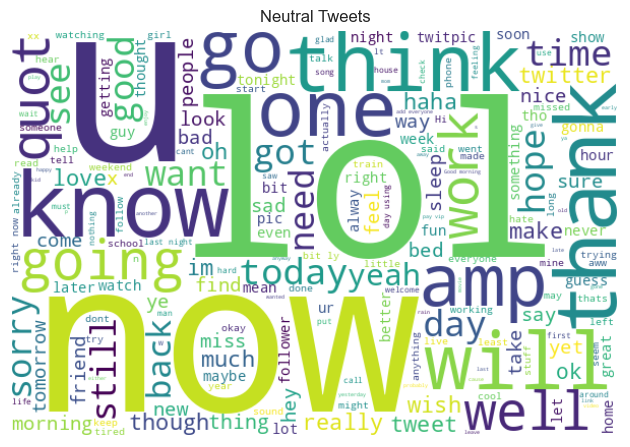

In [33]:
negative_cloud = WordCloud(stopwords=STOPWORDS, width=600, height=400, background_color='white').generate(df[df.sentiment == SENTIMENTS["neutral"]].text.str.cat(sep='\n'))
plt.imshow(negative_cloud, interpolation='bilinear')
plt.title('Neutral Tweets')
plt.axis("off")
plt.tight_layout()
plt.show()

### Preprocessing, Pipeline setup and Training

We use ngrams to include word locality (word context).

A logistic regression and naive bayes both show only medium performance across all classes, with improved predictive power on the positive and negative tweets.

> Both learners have trouble differentiating between neutral posts.
> As shown above, neutral tweets contain quite a lot of buzz words from the other two sentiments.
> The issue may either be in our synthetic dataset, or the relationship between the words or ngrams might be much more important.
> In the later case, we would be better off using a sequence classifier (LSTM, transformer).

We will try out one in the following.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sentiment"], train_size=0.7, random_state=SEED)

In [11]:
pipeline = Pipeline([
    ('preprocess', TweetPreprocessor()),
    ('tokenizer', TfidfVectorizer(
        stop_words='english',
        ngram_range=(1,2),
        max_features=20_000
    )),
    # ('clf', LogisticRegression(
    #     C=0.2,
    #     class_weight='balanced',
    #     max_iter=10_000,
    #     random_state=SEED,
    #     n_jobs=-1
    # )),
    ('clf', MultinomialNB(alpha=0.7))
])
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)

print(classification_report(y_test, y_hat, target_names=list(SENTIMENTS.keys())[:-1]))

              precision    recall  f1-score   support

    negative       0.71      0.31      0.43     12253
     neutral       0.57      0.72      0.64     28629
    positive       0.67      0.66      0.67     26617

    accuracy                           0.62     67499
   macro avg       0.65      0.56      0.58     67499
weighted avg       0.64      0.62      0.61     67499



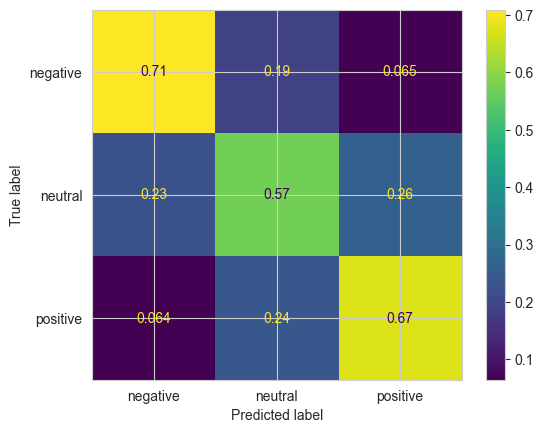

In [12]:
ConfusionMatrixDisplay.from_predictions(y_test, y_hat, display_labels=list(SENTIMENTS.keys())[:-1], normalize='pred')
plt.show()

### Transformer architecture for sentiment analysis